In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math,os
from numpy.random import choice
import scikitplot as skplt
from time import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_rows = 20
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [5]:
historicalColumns,neighborColumns,neighborColumnsAggregated = [],[],[]

for historical in range(5):
    historicalColumns += ['Tminus'+str(historical+1)]

for neighbor in range(26):
    neighborColumns += ['T'+str(neighbor+1)+'_t-1']
    
for neighborDegree in range(3):
        neighborColumnsAggregated += ['T_nbhDeg'+str(neighborDegree+1)+'_t-1']

columns = ['voxelLat','voxelLong','voxelVert','voxelType','timestep','x_voxel','y_voxel','z_voxel','layerNum','time_creation', 'time_elapsed', 'x_laser','y_laser','z_laser','x_distance','y_distance','z_distance','euclidean_distance_laser'] + historicalColumns+ neighborColumns + neighborColumnsAggregated + ['T_self']

In [6]:
len(columns)

53

In [7]:
def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

def isEven(num):
    if num%2 ==0:
        return True
    return False

def modLog(num):
    try:
        return log(num)
    except:
        return 0

def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return np.load(fullPath, allow_pickle=True)

In [8]:
#featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns
featureColumns = ['timestep','x_distance','y_distance','z_distance','time_elapsed'] + historicalColumns + neighborColumns

featureDisplay = featureColumns

In [9]:
len(featureColumns)

36

In [10]:
def plot_feature_importances(et):
    skplt.estimators.plot_feature_importances(et,text_fontsize=16,max_num_features=6,figsize=(24,4),feature_names=featureDisplay)

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
	'''
	scikit(sklearn) does not have support for mean absolute percentage error MAPE.
	This is because the denominator can theoretically be 0 and so the value would be undefined.
	So this is our implementation
	'''
# 	y_true = check_array(y_true)
# 	y_pred = check_array(y_pred)

	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def mse(y_true,y_pred):
    return roundup(mean_squared_error(y_true,y_pred))

def mae(y_true,y_pred):
    return roundup(mean_absolute_error(y_true,y_pred))

def mape(y_true, y_pred):
    return roundup(mean_absolute_percentage_error(y_true,y_pred))

In [12]:
def combineDataFrames(prefix,columns=columns):
    List = []
    nums_start,nums_stop = [],[]
    for item in os.listdir('../data/cube-20-20-10-800-processed'):
        if "cubeAgg-20-20-10-800_" in item and ".npy" in item:
            timeStep_start = int(item.split('cubeAgg-20-20-10-800_')[1].split('_')[0])
            nums_start += [timeStep_start]
            
            timeStep_stop = int(item.split('_')[2].split('.npy')[0])
            nums_stop += [timeStep_stop]
            
    nums_start = sorted(nums_start)
    nums_stop = sorted(nums_stop)
    
#     print (nums_start)
#     print (nums_stop)
    
    array = loadNumpy('../data/cube-20-20-10-800-processed/'+prefix+'_'+str(nums_start[0])+'_'+str(nums_stop[0])+'.npy')
    for i in range(1,len(nums_start)):
        newFile = '../data/cube-20-20-10-800-processed/'+prefix+'_'+str(nums_start[i])+'_'+str(nums_stop[i])+'.npy'
        array = np.append(array,loadNumpy(newFile),axis=0)
    return pd.DataFrame(array,columns=columns)


# def combineDataFrames(columns=columns):
#     dir = './temp/'
#     array = loadNumpy(dir+'file1.npy')
#     array = np.append(array,loadNumpy(dir+'file2.npy'),axis=0)
    
#     return pd.DataFrame(array,columns=columns)

In [13]:
# df_big = combineDataFrames('data_big')
df_big = combineDataFrames('cubeAgg-20-20-10-800')

In [14]:
df_big.shape

(9705190, 53)

In [23]:
df_train = df_big[df_big['timestep'] < 200.0]
df_test = df_big[(df_big['timestep'] >= 200.0) & (df_big['timestep'] < 1200.0)]


X_train = df_train.loc[:,featureColumns]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

In [24]:
et_500 = ExtraTreesRegressor(n_estimators=5, n_jobs=-1, random_state=300)
et_500.fit(X_train,y_train)
predicted = et_500.predict(X_test)
r2(y_test,predicted) ,mape(y_test,predicted)

(0.8276, 4.846)

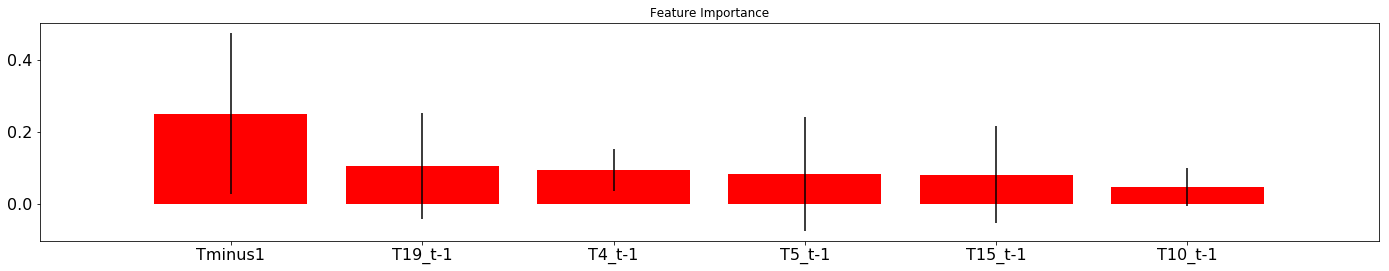

In [21]:
plot_feature_importances(et_500)